In [21]:
from math import cos, log10, sin
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import math as m

from RK_class import RK_method


In [40]:
class VIDE_RK_method(RK_method):
    def __init__(self, e, w, d, A, b, c, n=None):
        super().__init__(A, b, c, n)
        self.e=e
        self.w=w
        self.d=d
        self.method_param_check_()

    def method_param_check_(self):
        for i in range(self.s-1):
            assert self.d[i]>=self.c[i],f'{self.d[i]},< {self.c[i]}'
        assert len(self.e)==len(self.w),'w and e are vectors for counting intergration tail. they should have the same length.'
        assert len(self.d)==self.s,'d should be the same length as others method vectors = s.'
        
    def get_solution_VIDE(self, x0:float, x1:float, y0, f, K, h:float, limit=None):
        limit=limit if limit else lambda x:x0
        assert callable(f), "f(x,y,F)-eq for sol"
        assert callable(K), "K(x,s, y(s))-integration eq for sol"
        assert callable(y0), "y0(t) should retern past"
        assert x0+h<x1, "x0-start of sol, x1-end, h-step. It shouldnt be x0+h>x1"
        if(not self.b_teta):
            print('need some time for find b_teta')
            self.b_teta_calc()
            print('done it. Starting to calculate solution')

        def binarySearch(x, arr):
            mid = len(arr) // 2
            low = 0
            high = len(arr) - 1

            while arr[mid] != x and low <= high:
                if x > arr[mid]:
                    low = mid + 1
                else:
                    high = mid - 1
                mid = (low + high) // 2

            return mid
        def new_y(i, h, teta):
            if(teta==0):return Y[i]
            if(teta==1 and len(Y)-1!=i):return Y[i+1]
            return Y[i]+h*sum([F[i][j]*self.b_teta[j](teta) for j in range(4)])
        
        def integration_K(t):
            res = 0
            start = binarySearch(limit(t), X)
            end = binarySearch(t, X)
            if start<0:
                if end<0:
                    for i in range(limit(t), t, h):
                        res+=h*sum([self.w[j]*K(t, i+h*self.e[j],y0(i+h*self.e[j])) for j in range(len(self.w))])
                    return res
                for i in range(limit(t), x0, h):
                    res+=h*sum([self.w[j]*K(t, i+h*self.e[j],y0(i+h*self.e[j])) for j in range(len(self.w))])
                start+=1
            elif limit(t)!=X[start]:
                h_ = X[start + 1] - limit(t)
                res+=h_*sum([self.w[j]*K(t, limit(t)+h_*self.e[j],new_y(start, h_, self.e[j])) for j in range(len(self.w))])
                start+=1
            
            for i in range(start, end):
                res+=h*sum([self.w[j]*K(t, X[i]+h*self.e[j],new_y(i, h, self.e[j])) for j in range(len(self.w))])
                if(m.isnan(res)):
                    print(sum([self.w[j]*K(t, X[i]+h*self.e[j],new_y(i, h, self.e[j])) for j in range(len(self.w))]))
            
            return res
        
        def Y_Z_f(h):
            Y_=[]
            Z_=[]
            F_=[integration_K(X[-1]+self.c[i]*h) for i in range(self.s)]
            for i in range(self.s):
                for j in range(i):
                    if(m.isnan(f(X[-1]+self.c[j]*h,Y_[j],F_[j]+Z_[j]))):
                        print(X[-1]+self.c[j]*h,Y_[j],F_[j], Z_[j])
                Y_.append(Y[-1]+sum([self.A[i][j]*f(X[-1]+self.c[j]*h,Y_[j],F_[j]+Z_[j]) for j in range(i)]))
                Z_.append(h*sum([self.A[i][j]*K(X[-1]+self.d[j]*h,X[-1]+self.c[j]*h,Y_[j]) for j in range(i)]))
            f_=[f(X[-1]+self.c[i]*h,Y_[i],F_[i]+Z_[i]) for i in range(self.s)]
            return(f_)

        X=[x0]
        Y=[y0(x0)]
        F=[]
        while X[-1]+h<=x1:
            F.append(Y_Z_f(h))
            Y.append(new_y(len(F)-1, h, 1))
            X.append(X[-1]+h)
        if X[-1]!=x1:
            F.append(Y_Z_f(x1-X[-1]))
            Y.append(new_y(len(F)-1, h, 1))
            X.append(x1)
        return(X,Y) 
  

In [14]:
A = [[0,0,0,0],
   [1/2,0,0,0],
   [0,1/2,0,0],
   [0,0,1,0]]
b=[1/6,1/3,1/3,1/6]
c=[0,1/2,1/2,1]
d=[1/2, 1/2, 1, 0]
w=[1/6,2/3,1/6]
e=[0,1/2,1]
b_param=[lambda teta: teta-3/2*teta*teta+2/3*teta**3, 
        lambda teta: teta**2-2/3*teta**3,
        lambda teta: teta**2-2/3*teta**3,
        lambda teta: 2/3*teta**3-teta**2/2]

In [41]:
VIDE_RK_method1=VIDE_RK_method(e, w, d, A,b,c, 4)
VIDE_RK_method1.set_b_teta(b_param)

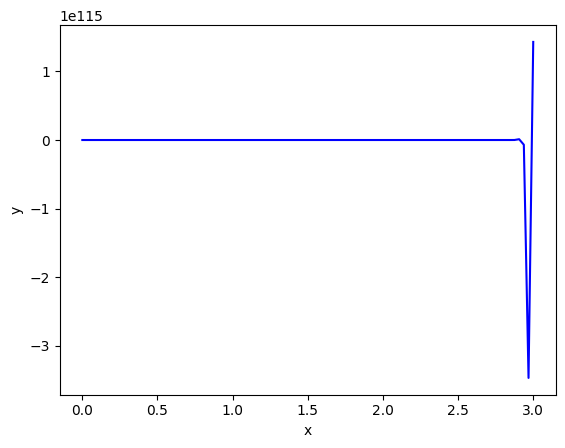

In [72]:
x0=0
def y0(x):
    return 1
x1=3
def K(x, s, y_s):
    return y_s
def f(x,y,F):
    return 6.4*y-4096*F
# def y_true(t):
#     return -cos(t)

X,Y=VIDE_RK_method1.get_solution_VIDE(x0, x1, y0, f, K, 1/2**5)
VIDE_RK_method1.get_Graph_Solution(X,Y)


[20, -60.0, -1199.9999999999995, 43620.0, -1088580.0000000005, 25156680.000000037, -569522460.0000012, 12818119380.000027, -288005660400.00073, 6467900602740.019, -145232285400660.53, 3260954888016377.5, -7.321854579857787e+16, 1.6439774596203515e+18, -3.6912220096599286e+19, 8.287896962371874e+20, -1.8608804836678358e+22, 4.178232549168064e+23, -9.381380081595671e+24, 2.1064000389350405e+26, -4.729497240917055e+27, 1.061913394142496e+29, -2.3843127485984328e+30, 5.35349428154599e+31, -1.202019367604368e+33, 2.698892506665409e+34, -6.059819798951269e+35, 1.3606105432160533e+37, -3.0549770648807206e+38, 6.859335989626492e+39, -1.5401258084542161e+41, 3.458042454042137e+42, -7.764338178294504e+43, 1.743325830961213e+45, -3.914287197578226e+46, 8.788743901463883e+47, -1.973335513380527e+49, 4.43072763528834e+50, -9.94830693766682e+51, 2.2336920495359926e+53, -5.015305823817359e+54, 1.1260859576252441e+56, -2.528399321012056e+57, 5.67701167322586e+58, -1.2746586850467274e+60, 2.86198947067

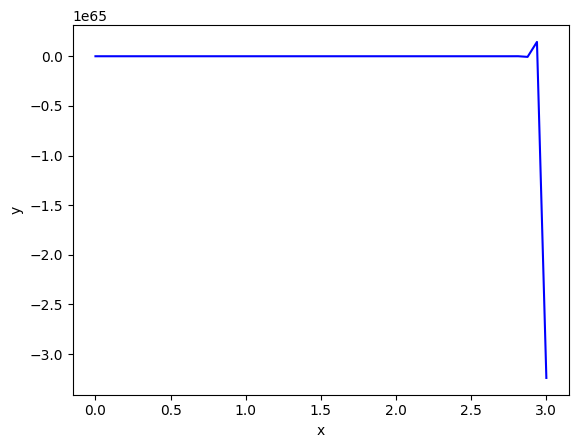

In [75]:
x0=0
def y0(x):
    return 20
x1=3

def K(x, s, y_s):
    return y_s
def f(x,y,F):
    return -16*y-1536*F
# def y_true(t):
#     return -cos(t)

X,Y=VIDE_RK_method1.get_solution_VIDE(x0, x1, y0, f, K, 1/2**4)
VIDE_RK_method1.get_Graph_Solution(X,Y)
print(Y)